In [1]:
%load_ext autoreload
%autoreload 1
%aimport utilsLoaders


In [2]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import ConvexHull

from tqdm.auto import tqdm, trange

from utilsLoaders import read_trc, read_mot
# import ocfeats

datadir = Path('./datadir')

def get_trc_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'MarkerData/PostAugmentation/{trial}/{trial}.trc'

def get_mot_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Kinematics/{trial}.mot'

def get_sto_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Dynamics/{trial}_shoulder.sto'

def get_model_path(sid):
    model_dir = datadir / f'opencap_data/{sid}/OpenSimData/Model/'
    return list(mdir.glob('*.osim'))[0]

    

In [3]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72



In [4]:
df_session = pd.read_excel(datadir / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / 'participant_info.xlsx')


  0%|          | 0/309 [00:00<?, ?it/s]

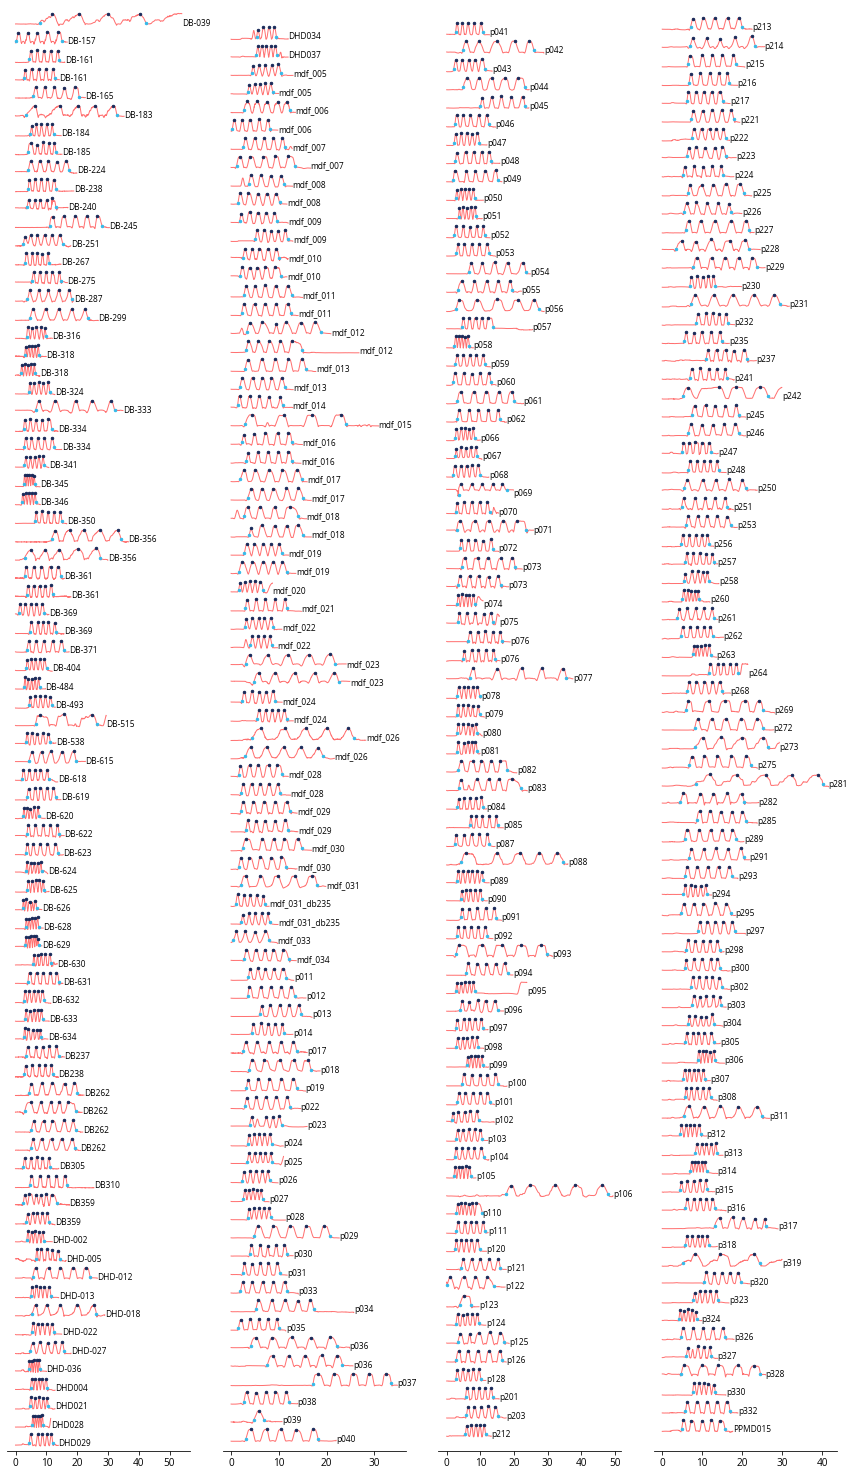

In [5]:
df_sts = df_trial[df_trial.trial_clean=='5xsts']
# df_sts = df_sts.iloc[:50]
n = len(df_sts)

ncols = 4

plt.figure(figsize=(3*ncols,n/15))

for i in trange(n, leave=False):
    row = df_sts.iloc[i]
    pid = row.pid

    # if pid not in ('mdf_015', 'mdf_006', 'mdf_018', 'mdf_023', 'p023', 'p037', 'p045', 'p069', 'p074', 'p095', 'p122'):
    #     continue
    
    sid, trial = row.sid, row.trial
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

    rh = xyz[:,np.argmax(markers=='RHJC_study'),:].copy()
    lh = xyz[:,np.argmax(markers=='lHJC_study'),:].copy()
    mh = (rh + lh) / 2

    h = mh[:,1]
    h -= h.min()
    h /= h.max()
    locs, _ = ss.find_peaks(h, height=0.75, prominence=0.5)

    la = locs[0] - np.argmax(h[locs[0]::-1] < 0.25)
    if la == locs[0]:
        la = np.argmin(h[:locs[0]])
    lb = locs[-1] + np.argmax(h[locs[-1]:] < 0.25)
    if lb == locs[-1]:
        lb = locs[-1] + np.argmin(h[locs[-1]:])

    t = np.arange(h.size) / fps

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t, h-i%(n/ncols)*1.5, lw=1, c=cp[1], zorder=-1)
    plt.scatter(t[locs], h[locs]-i%(n/ncols)*1.5, s=6, c=cp[0])
    plt.scatter(t[la], h[la]-i%(n/ncols)*1.5, s=6, c=cp[3])
    plt.scatter(t[lb], h[lb]-i%(n/ncols)*1.5, s=6, c=cp[3])
    plt.text(t[-1], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_sts.pdf')
plt.show()


  0%|          | 0/309 [00:00<?, ?it/s]

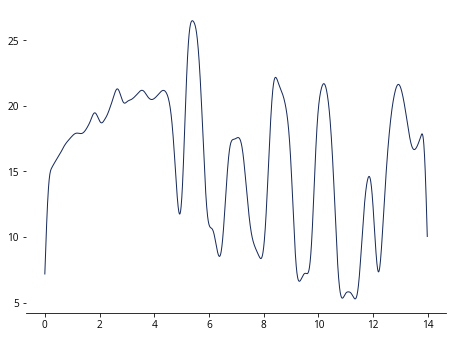

In [6]:
from utils import angle_between_all

df_sts = df_trial[df_trial.trial_clean=='5xsts']
n = len(df_sts)
for i in trange(n, leave=False):
    row = df_sts.iloc[i]
    pid = row.pid
    if pid == 'p247':
        break

sid, trial = row.sid, row.trial
fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

c7 = xyz[:,np.argmax(markers=='C7_study'),:]
# mh = xyz[:,np.argmax(markers=='midHip'),1]
rh = xyz[:,np.argmax(markers=='RHJC_study'),:]
lh = xyz[:,np.argmax(markers=='lHJC_study'),:]
mh = (rh + lh) / 2

h = mh[:,1].copy()
h -= h.min()
h /= h.max()
locs, _ = ss.find_peaks(h, height=0.75, prominence=0.5)

la = locs[0] - np.argmax(h[locs[0]::-1] < 0.25)
if la == locs[0]:
    la = np.argmin(h[:locs[0]])
lb = locs[-1] + np.argmax(h[locs[-1]:] < 0.25)
if lb == locs[-1]:
    lb = locs[-1] + np.argmin(h[locs[-1]:])

if len(locs) > 1:
    tdiffs = np.diff(locs) / fps
    sts_time = np.median(tdiffs)
else:
    sts_time = (lb - la)/fps

# sts_time = locs.ptp() / (len(locs)-1) / fps
sts_speed = 1 / sts_time

# sts_time_5 = sts_time * 5
sts_time_5 = (lb - la)/fps / len(locs) * 5

# gravity vector
grav = np.zeros_like(c7)
grav[:,1] = -1

trunk_angle = angle_between_all(mh-c7, grav) * 180 / np.pi

# smooth trunk angle with 0.5s hann window
win = ss.windows.hann(int(0.5*fps))
win /= np.sum(win)
trunk_angle = ss.convolve(trunk_angle, win, mode='same')

lean_ptps = []
lean_maxs = []
lean_avels = []
if len(locs) > 1:
    for i in range(len(locs)-1):
        la, lb = locs[i], locs[i+1]
        seg = trunk_angle[la:lb]
        lean_ptps.append(seg.ptp())
        lean_maxs.append(seg.max())
        lean_avels.append(np.max(np.diff(seg))*fps)
else:
    seg = trunk_angle[la:lb]
    lean_ptps.append(seg.ptp())
    lean_maxs.append(seg.max())
    lean_avels.append(np.max(np.diff(seg))*fps)

lean_ptp = np.median(lean_ptps)
lean_max = np.median(lean_maxs)
lean_avel = np.median(lean_avels)

t = np.arange(h.size) / fps

# plt.plot(t, mh[:,1], lw=1)
# plt.plot(t, c7[:,1], lw=1)
plt.plot(t, trunk_angle, lw=1)

sns.despine(left=True)
plt.tight_layout()
plt.show()


  0%|          | 0/309 [00:00<?, ?it/s]

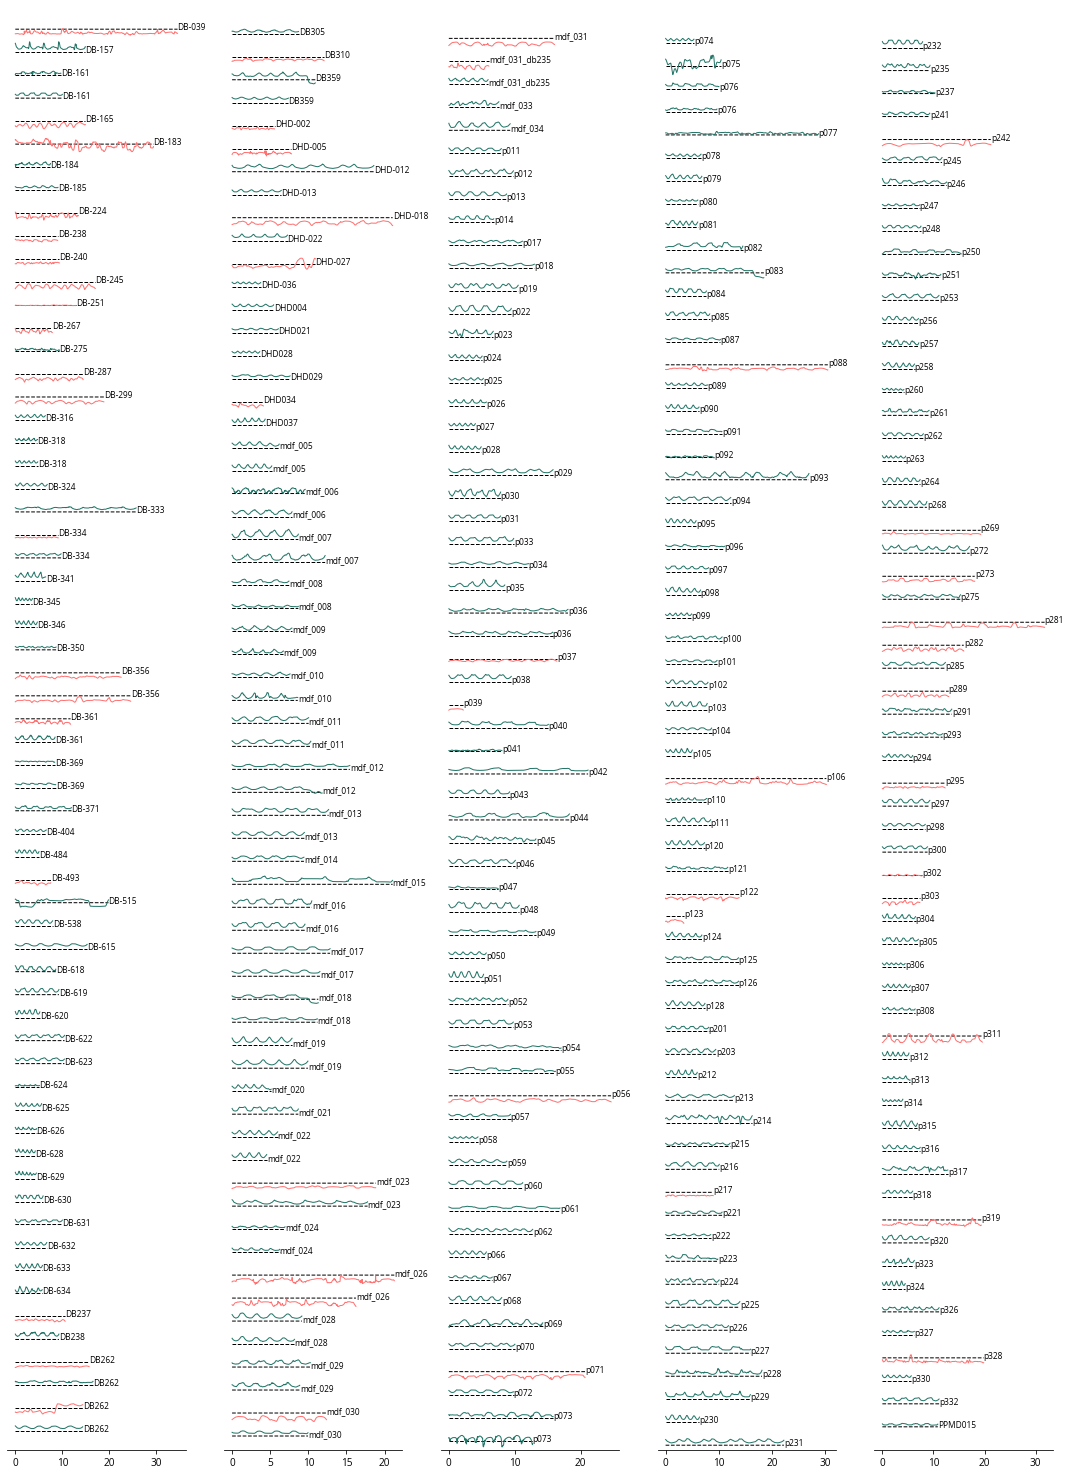

In [11]:
df_sts = df_trial[df_trial.trial_clean=='5xsts'].copy()
# df_sts = df_sts.iloc[:50]
n = len(df_sts)

ncols = 5

plt.figure(figsize=(3*ncols,n/ncols/3))

for i in trange(n, leave=False):
    row = df_sts.iloc[i]
    pid = row.pid
    sid, trial = row.sid, row.trial
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

    rh = xyz[:,np.argmax(markers=='RHJC_study'),:].copy()
    lh = xyz[:,np.argmax(markers=='lHJC_study'),:].copy()
    mh = (rh + lh) / 2

    h = mh[:,1]
    h -= h.min()
    h /= h.max()
    locs, _ = ss.find_peaks(h, height=0.75, prominence=0.5)

    la = locs[0] - np.argmax(h[locs[0]::-1] < 0.25)
    if la == locs[0]:
        la = np.argmin(h[:locs[0]])
    lb = locs[-1] + np.argmax(h[locs[-1]:] < 0.25)
    if lb == locs[-1]:
        lb = locs[-1] + np.argmin(h[locs[-1]:])

        
    rs = xyz[:,np.argmax(markers=='r_shoulder_study'),1]
    ls = xyz[:,np.argmax(markers=='L_shoulder_study'),1]
    ms = (rs + ls) / 2
    
    re = xyz[:,np.argmax(markers=='r_lelbow_study'),1]
    le = xyz[:,np.argmax(markers=='L_lelbow_study'),1]
    me = (re + le) / 2
    
    rw = xyz[:,np.argmax(markers=='r_lwrist_study'),1]
    lw = xyz[:,np.argmax(markers=='L_lwrist_study'),1]
    mw = (rw + lw) / 2
    
    rh = xyz[:,np.argmax(markers=='r_knee_study'),1]
    lh = xyz[:,np.argmax(markers=='L_knee_study'),1]
    mh = (rh + lh) / 2
    
    h = (mw - me) / (ms - mh)
    mean_hand_height = np.mean(h[la:lb])

        
    hands_down = h < 0
    uses_lap = hands_down[la:lb].mean() > 0.5

    color = cp[1] if uses_lap else cp[2]
    
    t = np.arange(h.size) / fps

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t[la:lb]-t[la], t[la:lb]*0-i%(n/ncols)*1.5, lw=1, ls='dashed', c='k', zorder=3)
    plt.plot(t[la:lb]-t[la], h[la:lb]-i%(n/ncols)*1.5, lw=1, c=color, zorder=3)
    plt.text(t[lb]-t[la], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)
    
    # break

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_sts2.pdf')
plt.show()


  0%|          | 0/309 [00:00<?, ?it/s]

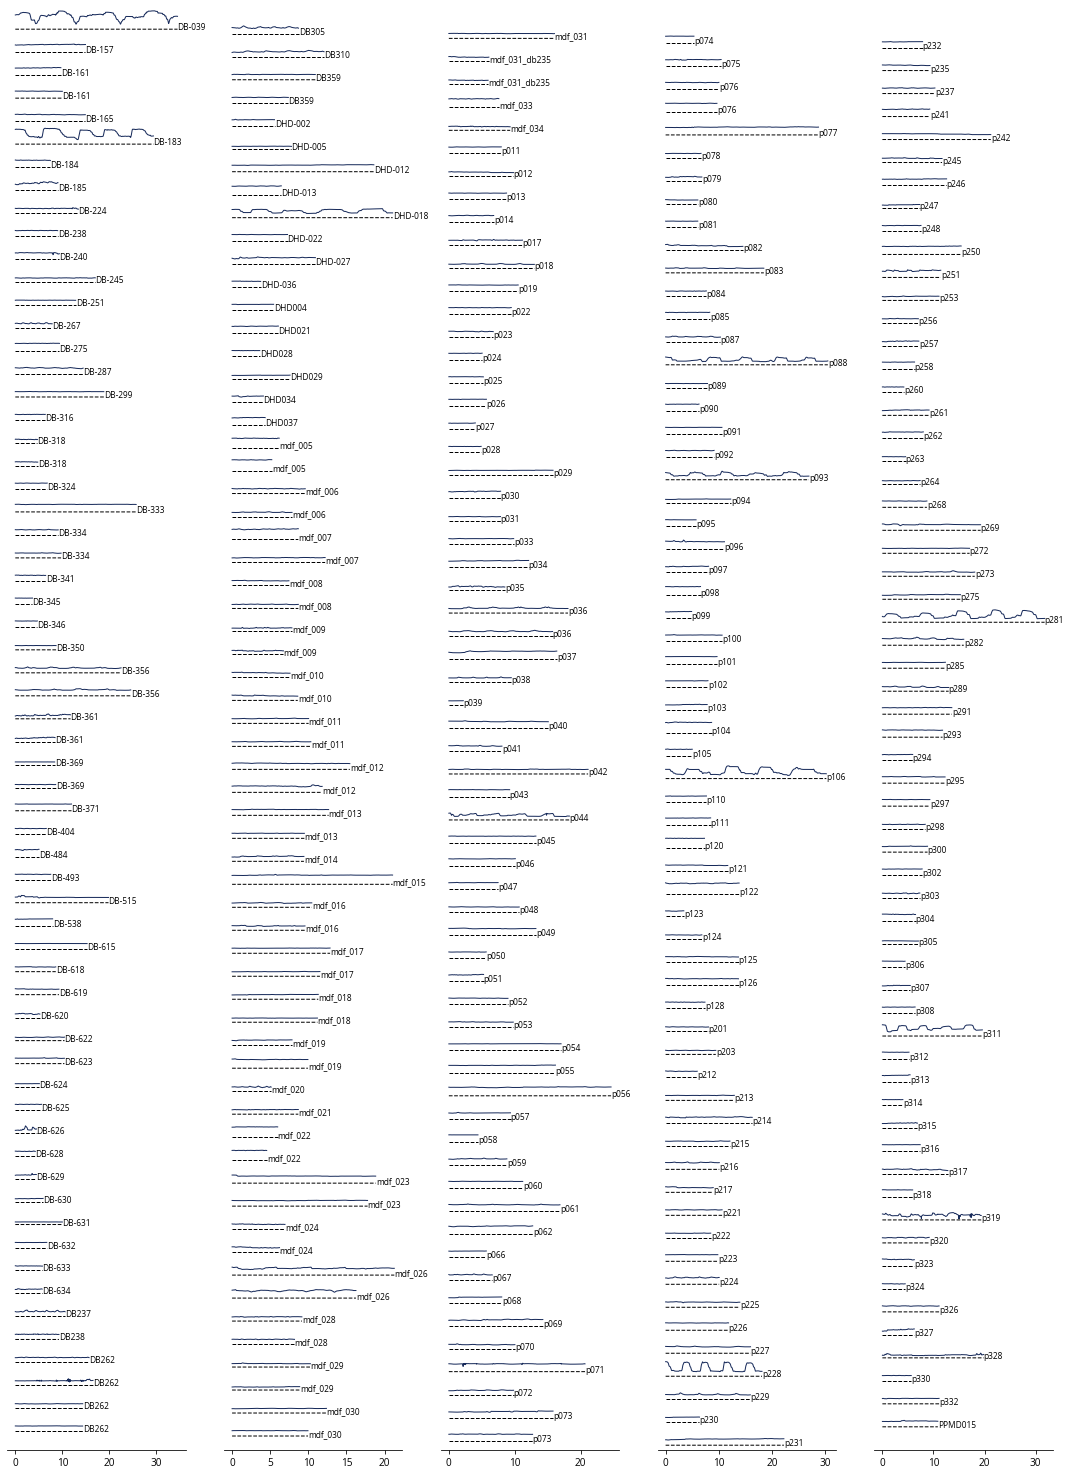

In [20]:
df_sts = df_trial[df_trial.trial_clean=='5xsts'].copy()
# df_sts = df_sts.iloc[:50]
n = len(df_sts)

ncols = 5

plt.figure(figsize=(3*ncols,n/ncols/3))

for i in trange(n, leave=False):
    row = df_sts.iloc[i]
    pid = row.pid
    sid, trial = row.sid, row.trial
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

    rh = xyz[:,np.argmax(markers=='RHJC_study'),:].copy()
    lh = xyz[:,np.argmax(markers=='lHJC_study'),:].copy()
    mh = (rh + lh) / 2

    h = mh[:,1]
    h -= h.min()
    h /= h.max()
    locs, _ = ss.find_peaks(h, height=0.75, prominence=0.5)

    la = locs[0] - np.argmax(h[locs[0]::-1] < 0.25)
    if la == locs[0]:
        la = np.argmin(h[:locs[0]])
    lb = locs[-1] + np.argmax(h[locs[-1]:] < 0.25)
    if lb == locs[-1]:
        lb = locs[-1] + np.argmin(h[locs[-1]:])

        
    rank = xyz[:,np.argmax(markers=='r_ankle_study'),:]
    lank = xyz[:,np.argmax(markers=='L_ankle_study'),:]
    ankle_dist = np.linalg.norm(lank - rank, axis=1)
    
    h = ankle_dist
    
    t = np.arange(h.size) / fps

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t[la:lb]-t[la], t[la:lb]*0-i%(n/ncols)*1.5, lw=1, ls='dashed', c='k', zorder=3)
    plt.plot(t[la:lb]-t[la], h[la:lb]-i%(n/ncols)*1.5, lw=1, c=cp[0], zorder=3)
    plt.text(t[lb]-t[la], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)
    
    # break

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_sts3.pdf')
plt.show()
